# TASK 7

Mount drive to the code for extraction of necessary data

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Install wavelets extension


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 38.4 MB/s eta 0:00:00


EEG Signal Classification Using Fourier and ZCR Features with SVM Model for Seizure Detection

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch
import pywt

# Path to dataset folders
train_data_path = "drive/MyDrive/EEG_Data/train_data"
validation_data_path = "drive/MyDrive/EEG_Data/validation_data"

# Labels mapping
label_mapping = {
    "Complex_Partial_Seizures": 0,
    "Electrographic_Seizures": 1,
    "Normal": 2,
    "Video_detected_Seizures_with_no_visual_change_over_EEG": 3
}

# Function to calculate time-domain features for one EEG sample
def extract_time_domain_features(eeg_data):
    features = {}
    for i, channel in enumerate(eeg_data):
        features[f'channel_{i+1}_mean'] = np.mean(channel)
        features[f'channel_{i+1}_variance'] = np.var(channel)
        features[f'channel_{i+1}_skewness'] = skew(channel)
        features[f'channel_{i+1}_kurtosis'] = kurtosis(channel)
        features[f'channel_{i+1}_zero_crossings'] = np.sum(np.diff(np.sign(channel)) != 0)
        features[f'channel_{i+1}_energy'] = np.sum(channel**2)
        features[f'channel_{i+1}_rms'] = np.sqrt(np.mean(channel**2))
    return features

# Function to calculate frequency-domain features (FFT and PSD)
def extract_frequency_domain_features(eeg_data, sampling_rate=256):
    features = {}
    for i, channel in enumerate(eeg_data):
        fft_values = np.fft.rfft(channel)
        fft_magnitude = np.abs(fft_values)

        features[f'channel_{i+1}_fft_mean'] = np.mean(fft_magnitude)
        features[f'channel_{i+1}_fft_variance'] = np.var(fft_magnitude)
        features[f'channel_{i+1}_fft_entropy'] = entropy(fft_magnitude)

        # Power Spectral Density (PSD)
        freqs, psd = welch(channel, fs=sampling_rate)
        features[f'channel_{i+1}_psd_mean'] = np.mean(psd)
        features[f'channel_{i+1}_psd_variance'] = np.var(psd)
    return features

# Function to calculate time-frequency features (Wavelet Transform)
def extract_wavelet_features(eeg_data, wavelet='db4', level=4):
    features = {}
    for i, channel in enumerate(eeg_data):
        coeffs = pywt.wavedec(channel, wavelet, level=level)
        for j, coeff in enumerate(coeffs):
            features[f'channel_{i+1}_wavelet_level_{j}_mean'] = np.mean(coeff)
            features[f'channel_{i+1}_wavelet_level_{j}_energy'] = np.sum(coeff**2)
    return features

# Function to calculate entropy-based features
def extract_entropy_features(eeg_data):
    features = {}
    for i, channel in enumerate(eeg_data):
        features[f'channel_{i+1}_shannon_entropy'] = entropy(np.histogram(channel, bins=10)[0])
    return features

# Function to process a dataset folder and extract features
def process_dataset(folder_path, label_mapping):
    all_features = []
    for label_folder in os.listdir(folder_path):  # Loop through label folders
        if label_folder in label_mapping:
            label = label_mapping[label_folder]
            folder_full_path = os.path.join(folder_path, label_folder)
            for file_name in os.listdir(folder_full_path):
                file_path = os.path.join(folder_full_path, file_name)
                eeg_data = np.load(file_path)  # Load EEG data (shape: channels x timepoints)

                # Extract features
                time_features = extract_time_domain_features(eeg_data)
                freq_features = extract_frequency_domain_features(eeg_data)
                wavelet_features = extract_wavelet_features(eeg_data)
                entropy_features = extract_entropy_features(eeg_data)

                # Combine all features
                features = {**time_features, **freq_features, **wavelet_features, **entropy_features}
                features['label'] = label
                features['file_name'] = file_name

                all_features.append(features)
    return pd.DataFrame(all_features)

# Process train and validation datasets
train_features = process_dataset(train_data_path, label_mapping)
validation_features = process_dataset(validation_data_path, label_mapping)

# Save extracted features
train_features.to_csv("train_all_features.csv", index=False)
validation_features.to_csv("validation_all_features.csv", index=False)

print("Feature extraction complete. All features saved to CSV.")


Feature extraction complete. All features saved to CSV.


Feature correlation matrix

Calculating Mutual Information...
Top 50 Features (Mutual Information): ['channel_10_rms', 'channel_10_energy', 'channel_10_variance', 'channel_10_wavelet_level_0_energy', 'channel_10_fft_variance', 'channel_10_fft_mean', 'channel_8_fft_mean', 'channel_13_wavelet_level_2_energy', 'channel_10_psd_mean', 'channel_13_fft_mean', 'channel_9_wavelet_level_0_energy', 'channel_9_rms', 'channel_9_energy', 'channel_10_psd_variance', 'channel_13_wavelet_level_4_energy', 'channel_9_variance', 'channel_9_fft_variance', 'channel_12_fft_mean', 'channel_9_fft_mean', 'channel_8_variance', 'channel_13_wavelet_level_3_energy', 'channel_12_wavelet_level_2_energy', 'channel_5_wavelet_level_1_energy', 'channel_14_fft_mean', 'channel_9_psd_mean', 'channel_13_wavelet_level_1_energy', 'channel_6_fft_mean', 'channel_8_fft_variance', 'channel_6_fft_variance', 'channel_12_wavelet_level_4_energy', 'channel_8_energy', 'channel_8_rms', 'channel_5_fft_mean', 'channel_6_rms', 'channel_6_energy', 'channel_15_fft_mean',

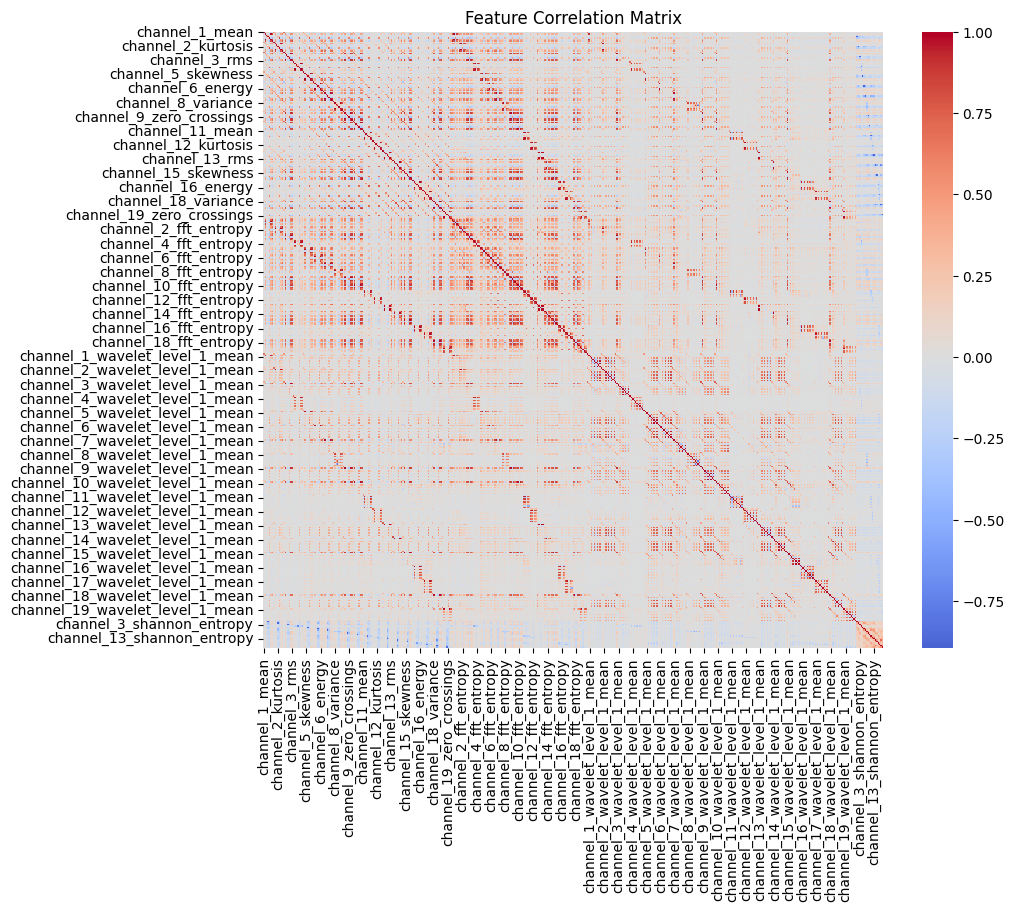

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Load extracted features
train_features = pd.read_csv("train_all_features.csv")

# Separate features and labels
X = train_features.drop(columns=["label", "file_name"])  # Drop non-feature columns
y = train_features["label"]

# 1. Mutual Information for Feature Selection
print("Calculating Mutual Information...")
mutual_info = mutual_info_classif(X, y, random_state=42)
mutual_info_df = pd.DataFrame({"Feature": X.columns, "Mutual_Info": mutual_info})
mutual_info_df = mutual_info_df.sort_values(by="Mutual_Info", ascending=False)

# Select top features based on mutual information
top_features_mi = mutual_info_df.head(50)["Feature"].tolist()  # Adjust number as needed
print(f"Top 50 Features (Mutual Information): {top_features_mi}")

# 2. Correlation Analysis
print("Performing Correlation Analysis...")
correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

threshold = 0.9
# Initialize a set to track features to drop
features_to_drop = set()

# Iterate over the upper triangle of the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            # Add only one feature to the drop set (e.g., the later one in the order)
            features_to_drop.add(correlation_matrix.columns[j])

# Drop the features
X_uncorrelated = X.drop(columns=features_to_drop)


In [ ]:
# Select only the features that are present in both X_uncorrelated and top_features_mi
common_features = [feature for feature in top_features_mi if feature in X_uncorrelated.columns]

# Combine the selected common features with the label
selected_features_df = X_uncorrelated[common_features]
selected_features_df["label"] = y

# Save the resulting dataset
selected_features_df.to_csv("train_selected_features.csv", index=False)
print("Feature selection complete. Saved to 'train_selected_features.csv'.")


<ipython-input-6-b308c4ad3956>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_df["label"] = y


Feature selection complete. Saved to 'train_selected_features.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Load extracted features
train_features = pd.read_csv("validation_all_features.csv")

# Separate features and labels
X = train_features.drop(columns=["label", "file_name"])  # Drop non-feature columns
y = train_features["label"]


# Select only the features that are present in both X_uncorrelated and top_features_mi
# common_features = [feature for feature in top_features_mi if feature in X_uncorrelated.columns]

# Combine the selected common features with the label
selected_features_df = X[common_features]
selected_features_df["label"] = y

# Save the resulting dataset
selected_features_df.to_csv("validate_selected_features.csv", index=False)
print("Feature selection complete. Saved to 'validated_selected_features.csv'.")


Feature selection complete. Saved to 'validated_selected_features.csv'.


<ipython-input-7-8354053d8c94>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_df["label"] = y


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6604 - loss: 0.9720 - val_accuracy: 0.7562 - val_loss: 0.6462
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7515 - loss: 0.6767 - val_accuracy: 0.7997 - val_loss: 0.5423
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7921 - loss: 0.5900 - val_accuracy: 0.8175 - val_loss: 0.5053
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8141 - loss: 0.5183 - val_accuracy: 0.8332 - val_loss: 0.4844
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8276 - loss: 0.5070 - val_accuracy: 0.8389 - val_loss: 0.4401
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8276 - loss: 0.4693 - val_accuracy: 0.8346 - val_loss: 0.4361
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8297 - loss: 0.4528 - val_accuracy: 0.8332 - val_loss: 0.4303
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8277 - loss: 0.4582 - val_accuracy:

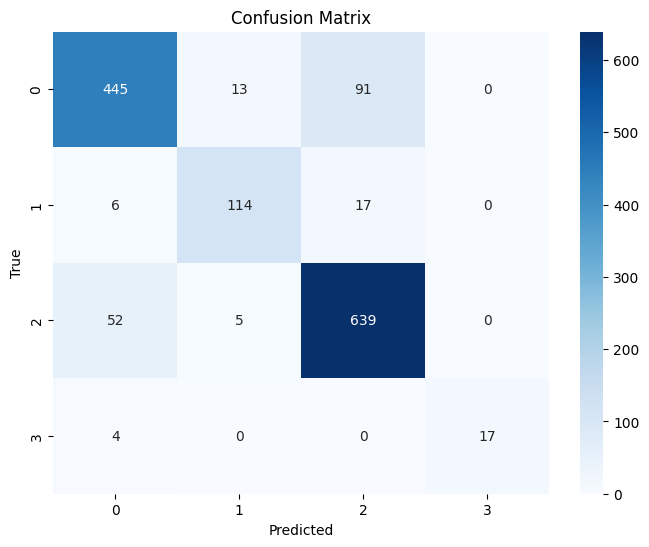

Hybrid CNN-LSTM model saved as 'hybrid_cnn_lstm_model.h5'.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
train_features = pd.read_csv("train_selected_features.csv")
validation_features = pd.read_csv("validate_selected_features.csv")  # Full validation set

# Prepare data
X_train = train_features.drop(columns=["label"])
y_train = train_features["label"]

X_val = validation_features.drop(columns=["label"])
y_val = validation_features["label"]

# Normalize the features
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_val.mean()) / X_val.std()

# Reshape for CNN-LSTM (samples, time-steps, features)
X_train = np.expand_dims(X_train.values, axis=2)  # Shape: (samples, time-steps, 1)
X_val = np.expand_dims(X_val.values, axis=2)

# Convert labels to one-hot encoding
num_classes = len(np.unique(y_train))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

# Build Hybrid CNN-LSTM Model
model = Sequential([
    # CNN Layers
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),

    # LSTM Layer
    LSTM(64, return_sequences=False),  # Extract temporal features
    Dropout(0.5),

    # Fully Connected Dense Layer
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Evaluate model
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

# ROC-AUC Score (One-vs-Rest)
roc_auc = roc_auc_score(y_val, model.predict(X_val), multi_class="ovr")
print(f"ROC-AUC Score: {roc_auc}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Save model
model.save("hybrid_cnn_lstm_model.h5")
print("Hybrid CNN-LSTM model saved as 'hybrid_cnn_lstm_model.h5'.")


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from kerastuner.tuners import BayesianOptimization
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load data
train_features = pd.read_csv("train_selected_features.csv")
validation_features = pd.read_csv("validate_selected_features.csv")

# Prepare data
X_train = train_features.drop(columns=["label"])
y_train = train_features["label"]

X_val = validation_features.drop(columns=["label"])
y_val = validation_features["label"]

# Normalize features
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_val.mean()) / X_val.std()

# Reshape for CNN-LSTM (samples, time-steps, features)
X_train = np.expand_dims(X_train.values, axis=2)
X_val = np.expand_dims(X_val.values, axis=2)

# Convert labels to one-hot encoding
num_classes = len(np.unique(y_train))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

# Define model-building function for Bayesian Optimization
def build_model(hp):
    model = Sequential()

    # First Conv1D layer
    model.add(Conv1D(
        filters=hp.Int('filters_1', min_value=16, max_value=64, step=16),
        kernel_size=hp.Int('kernel_size_1', min_value=3, max_value=7, step=2),
        activation='relu',
        input_shape=(X_train.shape[1], 1)
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Second Conv1D layer
    model.add(Conv1D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
        kernel_size=hp.Int('kernel_size_2', min_value=3, max_value=7, step=2),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # LSTM Layer
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        return_sequences=False  # Set to False to pass the final state to Dense layers
    ))
    model.add(Dropout(hp.Float('dropout_lstm', min_value=0.1, max_value=0.5, step=0.1)))

    # Fully connected layers
    model.add(Dense(
        units=hp.Int('units_dense', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_dense', min_value=0.1, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate the tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter configurations to try
    executions_per_trial=2,  # Average over multiple executions
    directory='hyperparameter_tuning',
    project_name='cnn_lstm_tuning'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=32)

# Retrieve the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Optimal Hyperparameters:
Filters (Layer 1): {best_hps.get('filters_1')}
Kernel Size (Layer 1): {best_hps.get('kernel_size_1')}
Dropout (Layer 1): {best_hps.get('dropout_1')}
Filters (Layer 2): {best_hps.get('filters_2')}
Kernel Size (Layer 2): {best_hps.get('kernel_size_2')}
Dropout (Layer 2): {best_hps.get('dropout_2')}
LSTM Units: {best_hps.get('lstm_units')}
Dropout (LSTM Layer): {best_hps.get('dropout_lstm')}
Units (Dense Layer): {best_hps.get('units_dense')}
Dropout (Dense Layer): {best_hps.get('dropout_dense')}
Learning Rate: {best_hps.get('learning_rate')}
""")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=32)

# Save the best model
best_model.save("optimized_cnn_lstm_model.h5")
print("Optimized Hybrid CNN-LSTM model saved as 'optimized_cnn_lstm_model.h5'.")


Trial 10 Complete [00h 00m 13s]

Best val_accuracy So Far: 0.8766928017139435
Total elapsed time: 00h 22m 00s

Optimal Hyperparameters:
Filters (Layer 1): 64
Kernel Size (Layer 1): 3
Dropout (Layer 1): 0.2
Filters (Layer 2): 96
Kernel Size (Layer 2): 3
Dropout (Layer 2): 0.30000000000000004
LSTM Units: 64
Dropout (LSTM Layer): 0.2
Units (Dense Layer): 64
Dropout (Dense Layer): 0.4
Learning Rate: 0.001

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7023 - loss: 0.9204 - val_accuracy: 0.7962 - val_loss: 0.5634
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7987 - loss: 0.5732 - val_accuracy: 0.8282 - val_loss: 0.4809
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8204 - loss: 0.5093 - val_accuracy: 0.8425 - val_loss: 0.4404
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8246 - loss: 0.4698 - val_accuracy: 0.8453 - val_loss: 0.4302
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8384 - loss:

Optimized Hybrid CNN-LSTM model saved as 'optimized_cnn_lstm_model.h5'.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense
import pandas as pd
import numpy as np

# Load data
train_features = pd.read_csv("train_selected_features.csv")
validation_features = pd.read_csv("validate_selected_features.csv")

# Prepare data
X_train = train_features.drop(columns=["label"])
y_train = train_features["label"]

X_val = validation_features.drop(columns=["label"])
y_val = validation_features["label"]

# Normalize features
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_val.mean()) / X_val.std()

# Reshape for CNN-LSTM (samples, time-steps, features)
X_train = np.expand_dims(X_train.values, axis=2)
X_val = np.expand_dims(X_val.values, axis=2)

# Convert labels to one-hot encoding
num_classes = len(np.unique(y_train))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

# Define the optimized model
model = Sequential()

# Layer 1: Conv1D + MaxPooling + Dropout
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Layer 2: Conv1D + MaxPooling + Dropout
model.add(Conv1D(filters=96, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM Layer
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))

# Fully Connected Dense Layer
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    batch_size=32
)

# Save the trained model
model.save("optimized_cnn_lstm_model.h5")
print("Optimized Hybrid CNN-LSTM model saved as 'optimized_cnn_lstm_model.h5'.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6736 - loss: 0.9346 - val_accuracy: 0.7983 - val_loss: 0.5539
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8065 - loss: 0.5540 - val_accuracy: 0.8175 - val_loss: 0.5047
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8170 - loss: 0.5151 - val_accuracy: 0.8332 - val_loss: 0.4615
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8269 - loss: 0.4757 - val_accuracy: 0.8375 - val_loss: 0.4305
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8332 - loss: 0.4557 - val_accuracy: 0.8375 - val_loss: 0.4764
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8405 - loss: 0.4370 - val_accuracy: 0.8425 - val_loss: 0.4248
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8381 - loss: 0.4280 - val_accuracy: 0.8539 - val_loss: 0.4077
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8493 - loss: 0.4031 - val_accuracy

Optimized Hybrid CNN-LSTM model saved as 'optimized_cnn_lstm_model.h5'.


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       549
           1       0.93      0.80      0.86       137
           2       0.86      0.88      0.87       696
           3       1.00      0.81      0.89        21

    accuracy                           0.86      1403
   macro avg       0.91      0.83      0.87      1403
weighted avg       0.86      0.86      0.86      1403

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ROC-AUC Score: 0.9736936170290361


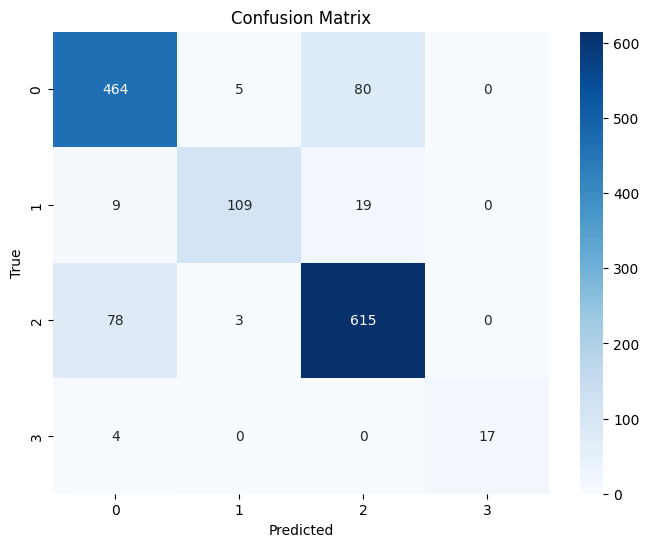

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
train_features = pd.read_csv("train_selected_features.csv")
validation_features = pd.read_csv("validate_selected_features.csv")  # Full validation set

# Prepare data
X_train = train_features.drop(columns=["label"])
y_train = train_features["label"]

X_val = validation_features.drop(columns=["label"])
y_val = validation_features["label"]

# Normalize the features
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_val.mean()) / X_val.std()

# Reshape for CNN-LSTM (samples, time-steps, features)
X_train = np.expand_dims(X_train.values, axis=2)  # Shape: (samples, time-steps, 1)
X_val = np.expand_dims(X_val.values, axis=2)

# Convert labels to one-hot encoding
num_classes = len(np.unique(y_train))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

# Load the best model from Bayesian Optimization (assuming 'best_model' is the best model returned by tuner)
best_model = tf.keras.models.load_model("optimized_cnn_lstm_model.h5")

# Evaluate the model
y_pred = np.argmax(best_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# ROC-AUC Score (One-vs-Rest)
roc_auc = roc_auc_score(y_val, best_model.predict(X_val), multi_class="ovr")
print(f"ROC-AUC Score: {roc_auc}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(X_uncorrelated.columns)

Index(['channel_1_mean', 'channel_1_variance', 'channel_1_skewness',
       'channel_1_kurtosis', 'channel_1_zero_crossings', 'channel_1_rms',
       'channel_2_mean', 'channel_2_variance', 'channel_2_skewness',
       'channel_2_kurtosis',
       ...
       'channel_10_shannon_entropy', 'channel_11_shannon_entropy',
       'channel_12_shannon_entropy', 'channel_13_shannon_entropy',
       'channel_14_shannon_entropy', 'channel_15_shannon_entropy',
       'channel_16_shannon_entropy', 'channel_17_shannon_entropy',
       'channel_18_shannon_entropy', 'channel_19_shannon_entropy'],
      dtype='object', length=319)
